## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [146]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn_image as isns
import seaborn as sns
import scipy.signal as signal
from scipy import stats

from sonar import sonar, utils
import math

In [148]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [155]:
relevant_cluster_labels =  [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',

 'Gamma (PP)',

 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',

]

In [150]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


## real tissue example

In [6]:
sample_list = []
for sample in range(1,5):
    n_sample = sample

    tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]
    # Islet stack
    rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
    # rescaled_splitted = np.split(rescaled, 16)
    # islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])
    sample_list.append(rescaled)


Text(0.5, 1.0, 'Sample4, scaling = 0.3')

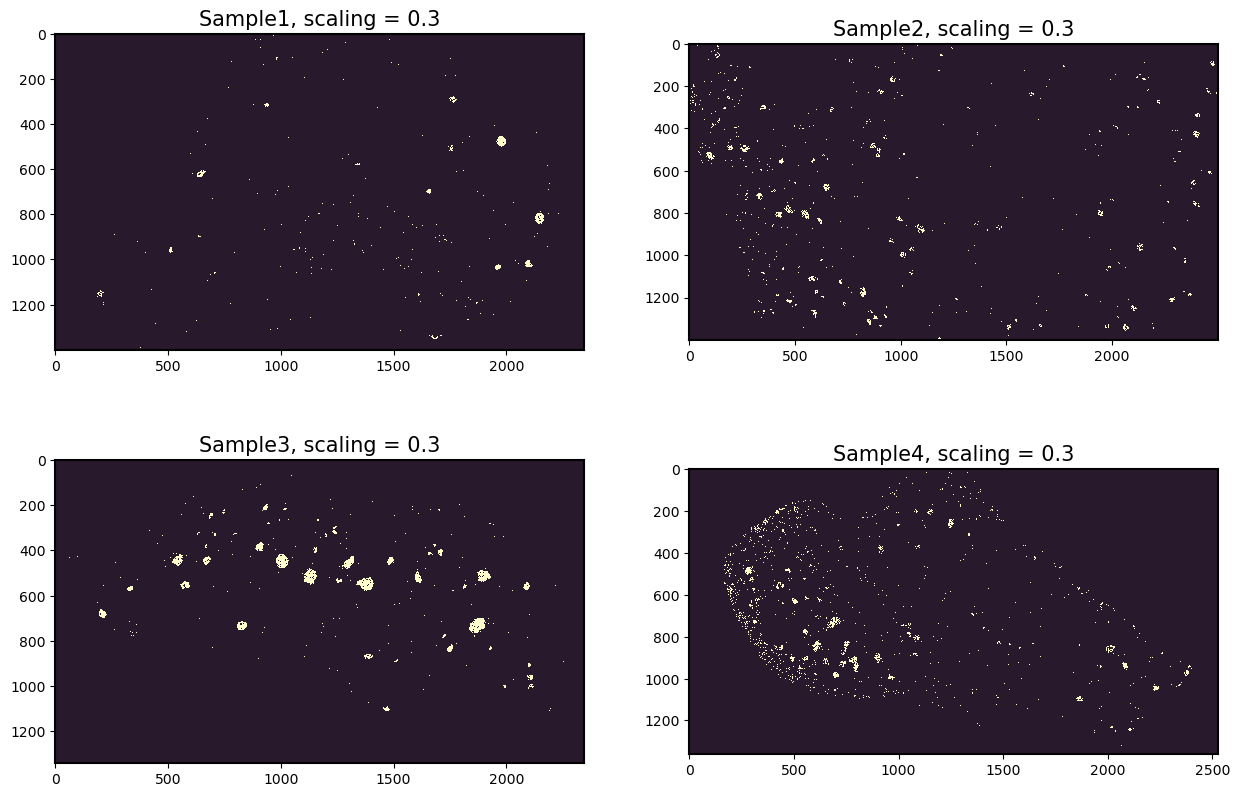

In [330]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(sample_list[0][0][200:1600,:])
plt.title("Sample1, scaling = 0.3")

plt.subplot(2,2,2)
plt.imshow(sample_list[1][0][350:1750,500:3000])
plt.title("Sample2, scaling = 0.3")

plt.subplot(2,2,3)
plt.imshow(sample_list[2][0].T)
plt.title("Sample3, scaling = 0.3")

plt.subplot(2,2,4)
plt.imshow(sample_list[3][0][200:,:])
plt.title("Sample4, scaling = 0.3")

# Normalization

In [151]:
rescaled = sample_list[0]

In [154]:
rescaled = rescaled[(1,2,3,4,5,6,8,10,11,12),:,:] # no more schwan, beta and delta cells

In [156]:
rescaled.shape

(10, 1788, 2343)

In [158]:
# calculation of the tissue area of each cell-type
def total_pixel_counts(original_img = rescaled, cell_type_labels = relevant_cluster_labels):

    # fig, ax = plt.figure(figsize=[10,3])

    tissue_pixels = []
    for i in range(len(cell_type_labels)):
        pix_agreg = np.sum(rescaled[i]) 
        tissue_pixels.append(pix_agreg)
        # print(pix_agreg)

    # ax.bar(cell_type_labels,tissue_pixels)
    # ax.set_xticks(rotation=45, ha="right")

    # plt.show()

    return list(tissue_pixels)

pixel_counts = total_pixel_counts(rescaled)

In [159]:
pixel_counts

[76427.0,
 696597.0,
 4112.0,
 3774.0,
 4405.0,
 2195.0,
 547.0,
 56161.0,
 8143.0,
 1017.0]

In [160]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

In [162]:
son = sonar.Sonar(max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)
radii, cooc_template_  = son.co_occurrence_from_tensor(rescaled,interpolate=None, area_normalization = True) 

In [163]:

# Normalisation to the number of pixels of cell-types in the tissue

def normalize_co_occurrence_matrix(tensor = cooc_template_, cell_counts = pixel_counts):
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / cell_counts[j]
    
    return normalized_coocur


normalized_coocur = normalize_co_occurrence_matrix(cooc_template_)

In [164]:
normalized_coocur.shape

(10, 10, 37)

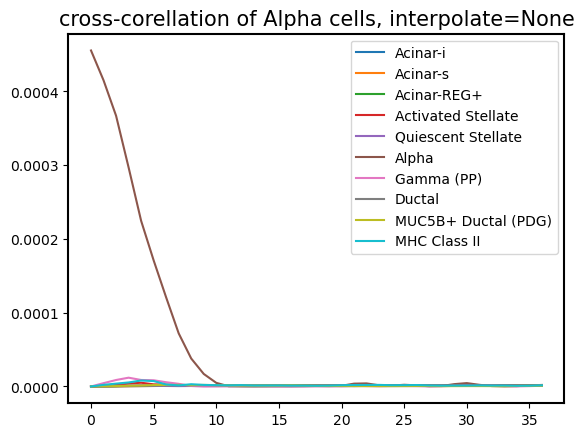

In [165]:
    
for i in range(normalized_coocur.shape[0]):
    plt.plot(normalized_coocur[5,i], label = relevant_cluster_labels[i])
    plt.title("cross-corellation of Alpha cells, interpolate=None")
    plt.legend()


In [166]:
# x = np.array(cooc_template_[5,:13,10])
x_list = [] #list of cross-correlation values per each distance
for i in range(normalized_coocur.shape[2]):
    x = np.array(normalized_coocur[5,:,i])
    x_list.append(x)

IndexError: list index out of range

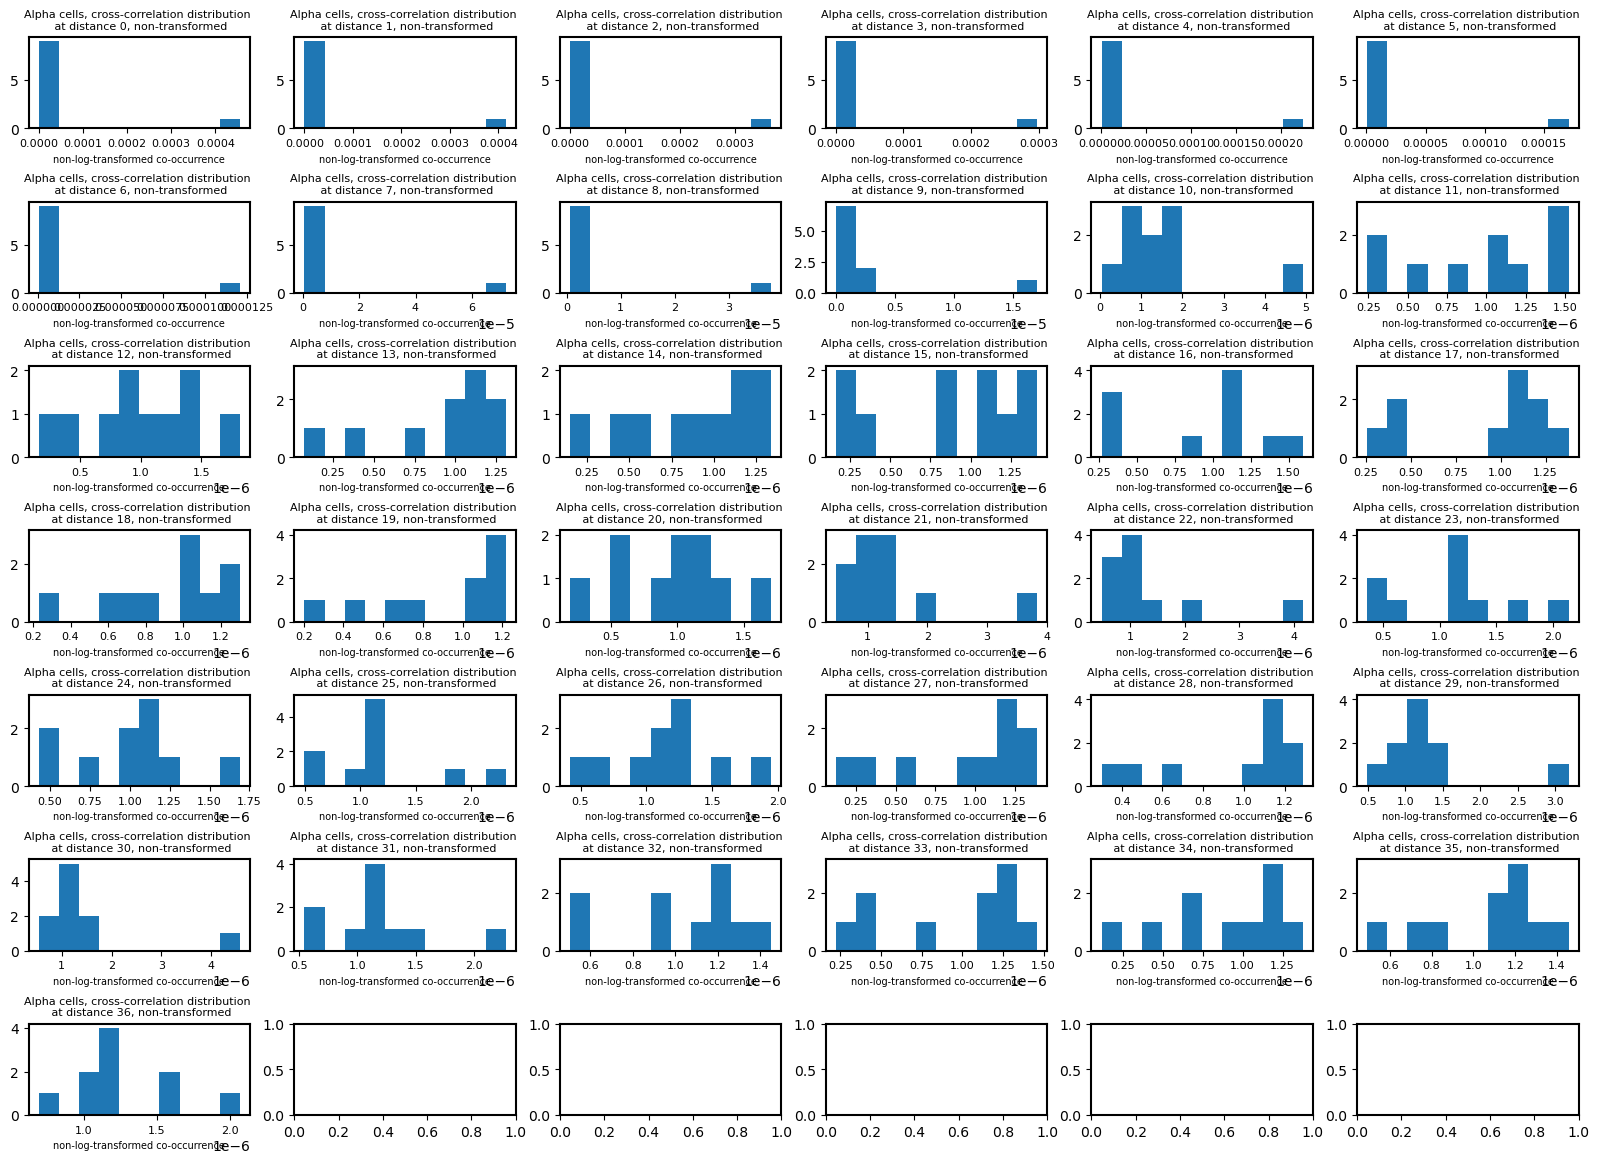

In [168]:
fig, axes = plt.subplots(7,6, figsize = (20,14), gridspec_kw={'hspace': 0.8})

num_rows = 7
num_cols = 6

for i in range(num_rows):
    for j in range(num_cols):
        ax = axes[i,j]

        data_index = i * num_cols + j

        ax.hist(x_list[data_index])
        ax.set_title(f'Alpha cells, cross-correlation distribution \n at distance {data_index}, non-transformed', fontsize=8)
        ax.set_xlabel('non-log-transformed co-occurrence', fontsize=7)
        ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()

/tmp/ipykernel_976906/950773883.py:13: RuntimeWarning: invalid value encountered in log
  ax.hist(np.log(x_list[data_index]))


IndexError: list index out of range

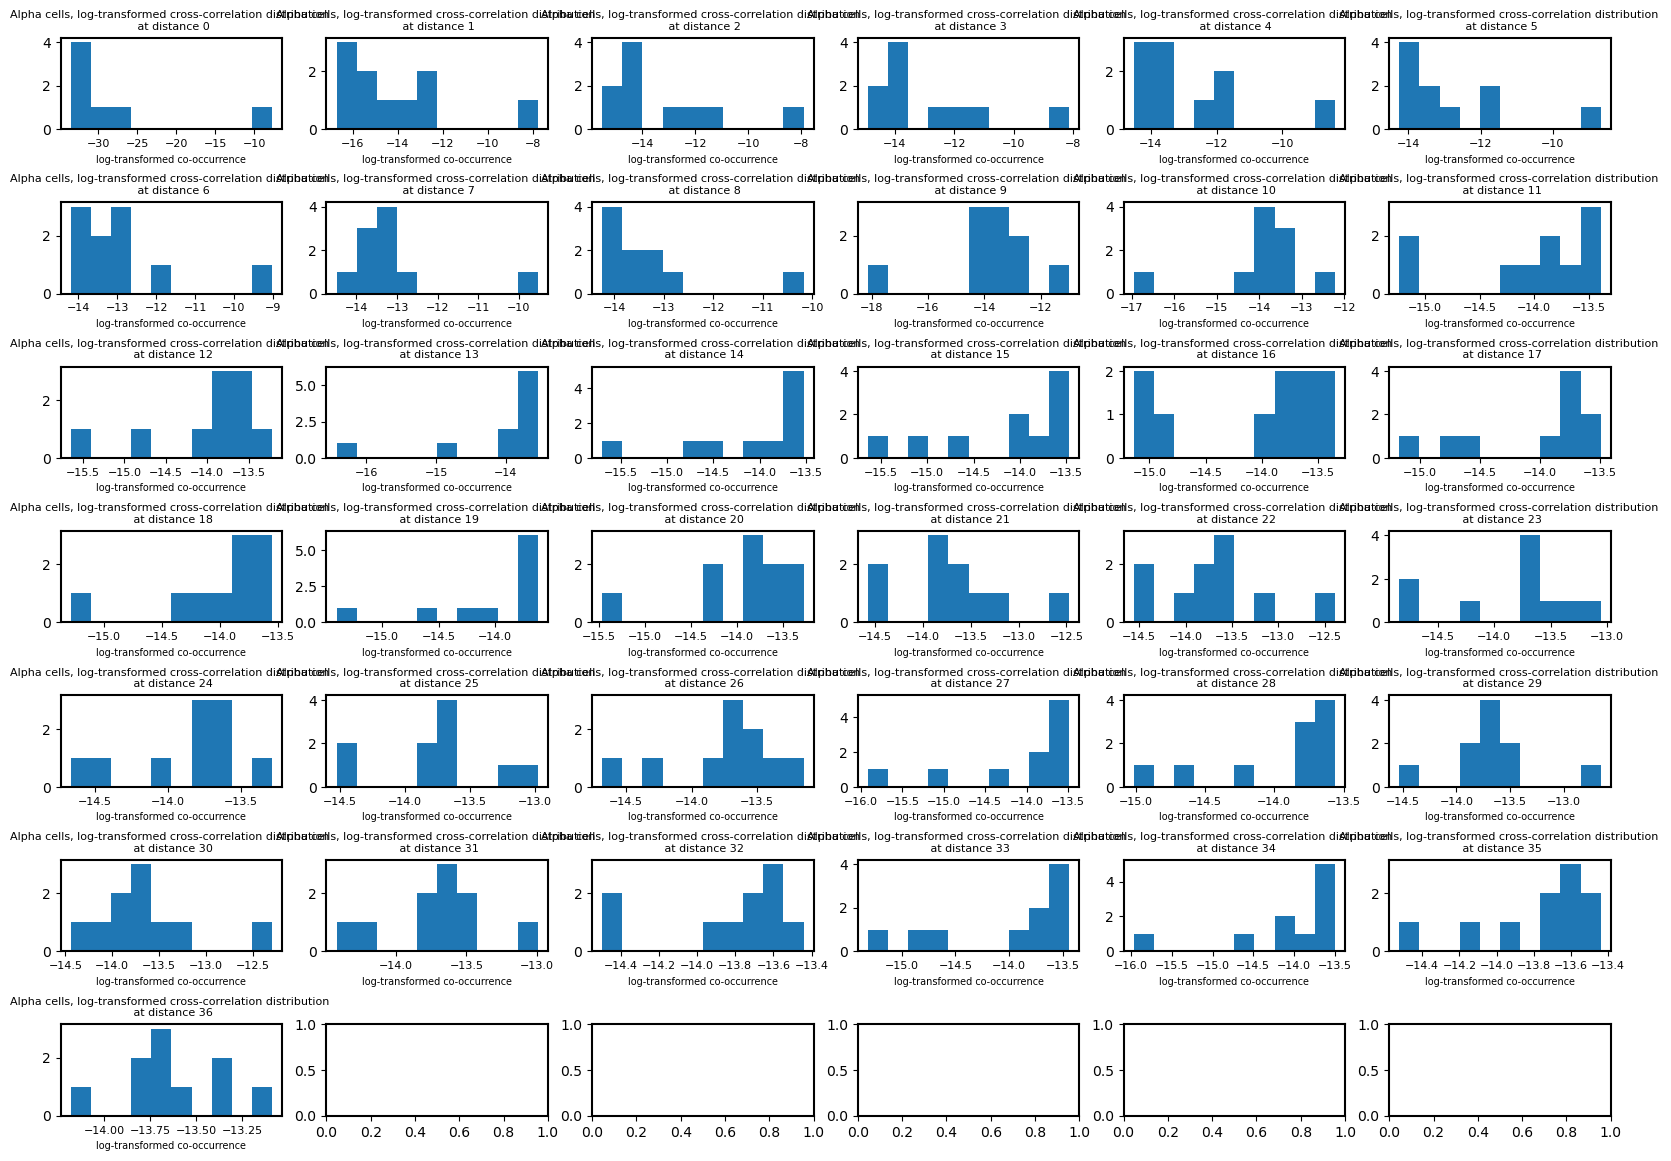

In [169]:
# log-transformed values
fig, axes = plt.subplots(7,6, figsize = (20,14), gridspec_kw={'hspace': 0.8})

num_rows = 7
num_cols = 6

for i in range(num_rows):
    for j in range(num_cols):
        ax = axes[i,j]

        data_index = i * num_cols + j

        ax.hist(np.log(x_list[data_index]))
        ax.set_title(f'Alpha cells, log-transformed cross-correlation distribution \n at distance {data_index}', fontsize=8)
        ax.set_xlabel('log-transformed co-occurrence', fontsize=7)
        ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()

In [172]:
from scipy import stats
# x = np.array([.... 13 values from sonar curve ....])

normality_check = np.empty((0,))

# log_x_list = np.log(x_list)

for x in x_list:
    res = stats.normaltest(x)
    dist = stats.chi2(df=2) # null distribution for very large samples is the chi-squared distribution with two degrees of freedom
    norm_res = dist.sf(res.statistic)
    normality_check = np.append(normality_check, norm_res)

normality_check


array([6.29757138e-07, 6.32513846e-07, 6.42533927e-07, 6.66363359e-07,
       6.79436709e-07, 6.99454544e-07, 6.68883702e-07, 6.66713016e-07,
       7.25368667e-07, 1.19142416e-06, 2.61903651e-04, 5.74180525e-01,
       8.51013613e-01, 1.24456617e-01, 5.49229347e-01, 4.33838572e-01,
       4.84378676e-01, 3.73823770e-01, 2.73017951e-01, 3.74673126e-01,
       9.26010984e-01, 5.37327159e-04, 2.45813852e-04, 8.71002545e-01,
       8.62162644e-01, 1.60732648e-01, 7.60514503e-01, 3.54727709e-01,
       2.62821358e-01, 1.04720848e-04, 8.69859553e-06, 5.77879835e-02,
       4.70214665e-01, 3.58168436e-01, 4.41398267e-01, 4.18420511e-01,
       3.60796865e-01])

In [173]:
for i in normality_check:
    if i >= 0.05:
        print(i)

0.5741805253436862
0.8510136125960772
0.12445661744497873
0.5492293474396037
0.43383857225009237
0.484378676442512
0.3738237702718865
0.27301795135096524
0.3746731258665603
0.9260109839621714
0.8710025446750194
0.8621626442390855
0.160732647950481
0.7605145034201695
0.354727708518779
0.2628213577857003
0.05778798346675546
0.4702146645421066
0.3581684358281937
0.4413982674815098
0.418420510652626
0.3607968646823217


In [174]:
normality_check2D = normality_check[:, np.newaxis]

normality_check2D.shape

(37, 1)

Text(0.5, 1.0, 'Normality heatmap of Alpha cells cross-correlation. Reduced data')

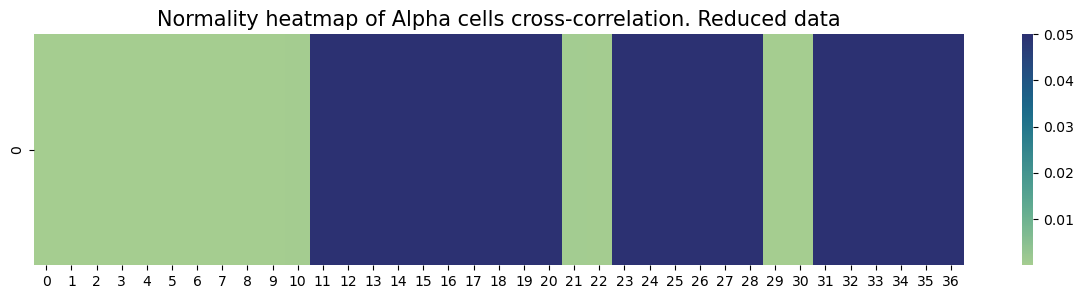

In [176]:
plt.figure(figsize = (15,3))

# plt.subplot(1,2,1)
sns.heatmap(normality_check2D.T, cmap="crest", vmax = 0.05)

plt.title("Normality heatmap of Alpha cells cross-correlation. Reduced data")

# plt.subplot(1,2,2)
# sns.heatmap(input_array.T, cmap="flare", vmax = 0.05)



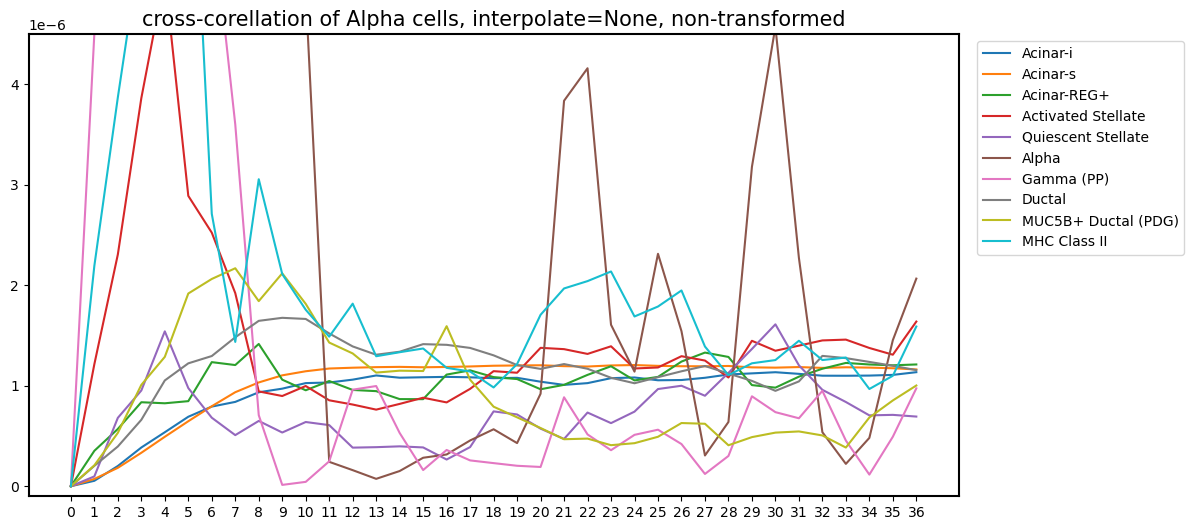

In [191]:
plt.figure(figsize=(12,6))

distances = normalized_coocur.shape[2]
cell_type_num = normalized_coocur.shape[0]


for i in range(cell_type_num):
    plt.plot(np.arange(distances),normalized_coocur[5,i], label = relevant_cluster_labels[i])
    plt.title("cross-corellation of Alpha cells, interpolate=None, non-transformed")
plt.ylim(-0.0000001,0.0000045)
plt.xticks(np.arange(distances))
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.show()

/tmp/ipykernel_976906/2741761301.py:7: RuntimeWarning: invalid value encountered in log
  plt.plot(np.arange(distances),np.log(normalized_coocur[5,i]), label = relevant_cluster_labels[i])


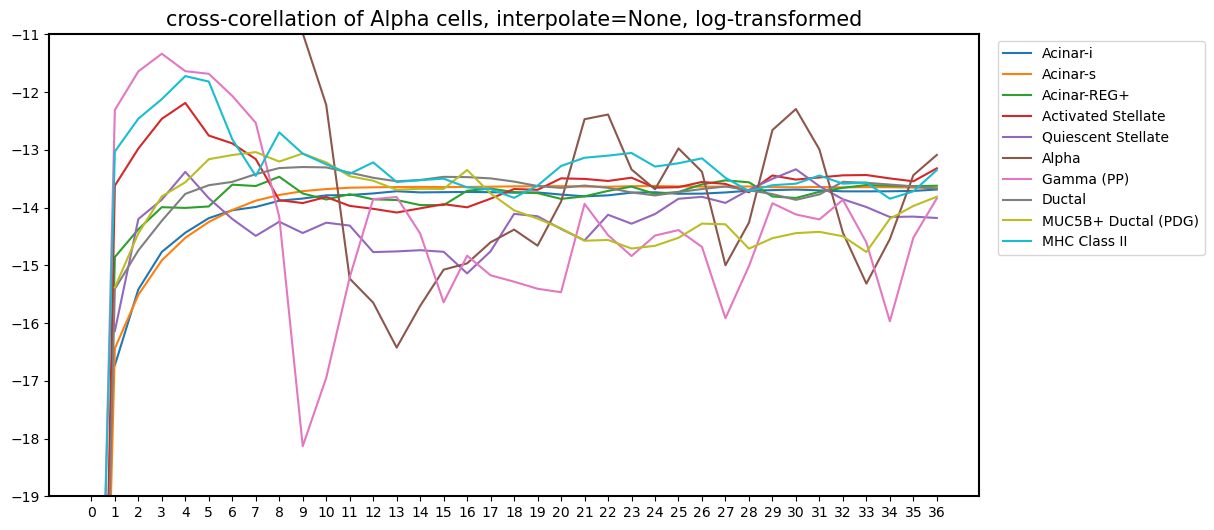

In [194]:
plt.figure(figsize=(12,6))

distances = normalized_coocur.shape[2]
cell_type_num = normalized_coocur.shape[0]

for i in range(cell_type_num):
    plt.plot(np.arange(distances),np.log(normalized_coocur[5,i]), label = relevant_cluster_labels[i])
    plt.title("cross-corellation of Alpha cells, interpolate=None, log-transformed")
plt.ylim(-19,-11)
plt.xticks(np.arange(distances))
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.show()

In [197]:
from scipy import stats
# x = np.array([.... 13 values from sonar curve ....])

log_normality_check = np.empty((0,))

log_x_list = np.log(x_list)

for x in log_x_list:
    res = stats.normaltest(x)
    dist = stats.chi2(df=2) # null distribution for very large samples is the chi-squared distribution with two degrees of freedom
    norm_res = dist.sf(res.statistic)
    log_normality_check = np.append(log_normality_check, norm_res)

log_normality_check2D = log_normality_check[:, np.newaxis]

/tmp/ipykernel_976906/3030362004.py:6: RuntimeWarning: invalid value encountered in log
  log_x_list = np.log(x_list)
/dh-projects/ag-ishaque/analysis/anastasiia/anaconda3/envs/sonar/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(0.5, 1.0, 'Normality heatmap of Alpha cells cross-correlation, log-transformed')

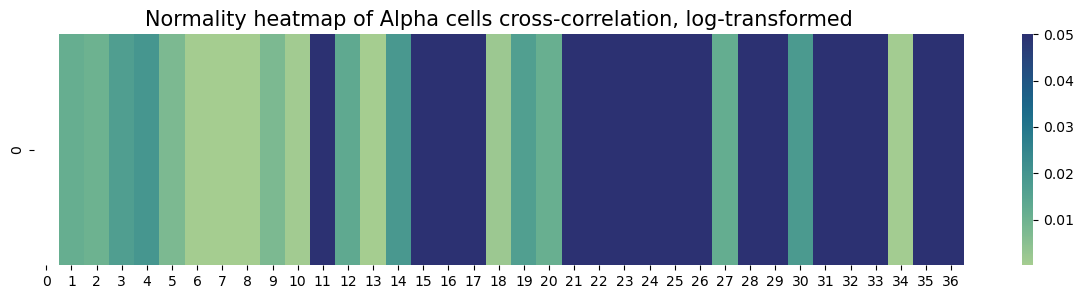

In [199]:
plt.figure(figsize = (15,3))

# plt.subplot(1,2,1)
sns.heatmap(log_normality_check2D.T, cmap="crest", vmax = 0.05)

plt.title("Normality heatmap of Alpha cells cross-correlation, log-transformed")

# plt.subplot(1,2,2)
# sns.heatmap(input_array.T, cmap="flare", vmax = 0.05)

/tmp/ipykernel_976906/277467074.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(np.arange(37),np.log(normalized_coocur[5,i]))


IndexError: index 10 is out of bounds for axis 1 with size 10

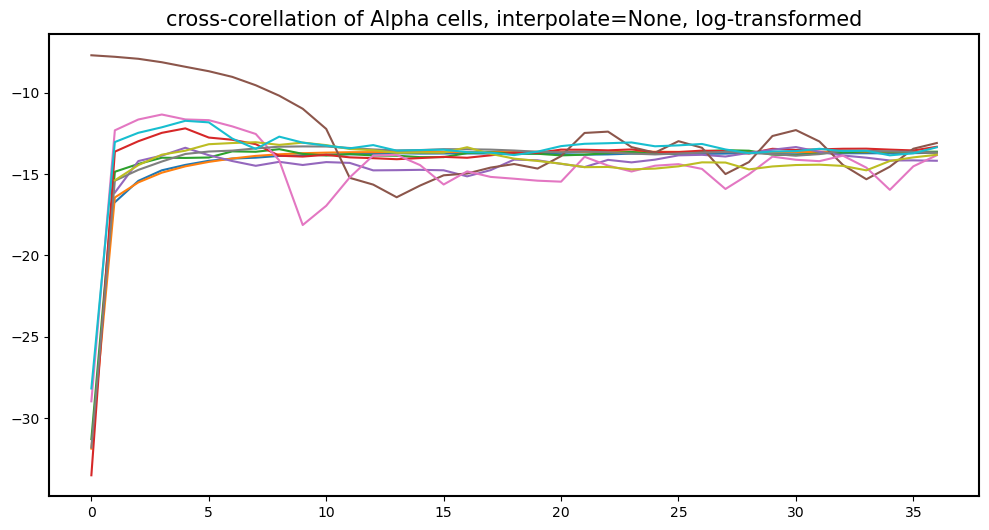

In [200]:
plt.figure(figsize=(12,6))

for i in range(13):
    plt.plot(np.arange(37),np.log(normalized_coocur[5,i]))
    plt.title("cross-corellation of Alpha cells, interpolate=None, log-transformed")
plt.ylim(-17,-12)
plt.xticks(np.arange(37))
plt.show()

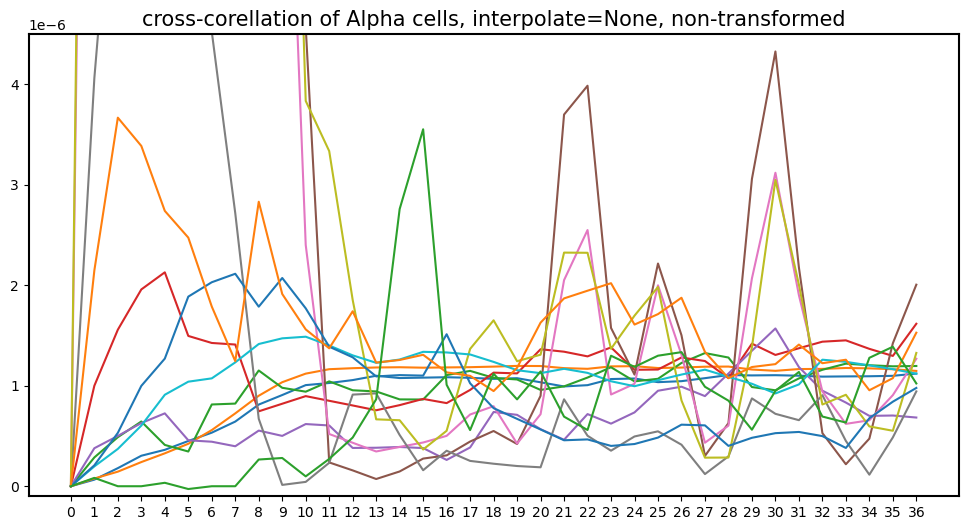

In [67]:
plt.figure(figsize=(12,6))

for i in range(13):
    plt.plot(np.arange(37),normalized_coocur[5,i])
    plt.title("cross-corellation of Alpha cells, interpolate=None, non-transformed")
plt.ylim(-0.0000001,0.0000045)
plt.xticks(np.arange(37))
plt.show()

## Crosscorrelation for all cells

In [252]:
# test_sapmple = normalized_coocur[:,:,10:]

/tmp/ipykernel_976906/3365158642.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(normalized_coocur[5,i]), label=relevant_cluster_labels[i])


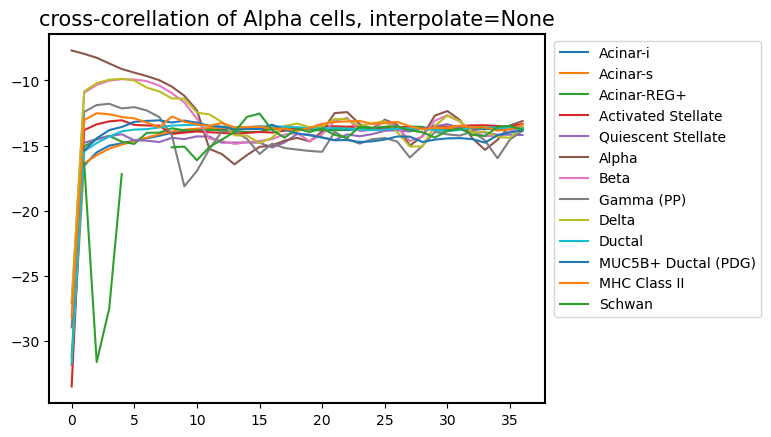

In [31]:
for i in range(13):
    plt.plot(np.log(normalized_coocur[5,i]), label=relevant_cluster_labels[i])
    plt.title("cross-corellation of Alpha cells, interpolate=None")
    plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1))
    # plt.xlim(10,37)
    # plt.ylim(-17,-12)

In [140]:
p_values_for_significance_test = np.zeros((13,37))

for i in range(13):
    for j in range(37):
        value_to_test = normalized_coocur[5,i,j]
        t_statistic, p_value = stats.ttest_1samp(normalized_coocur[5,:,0], value_to_test)
        p_values_for_significance_test[i,j] = p_value


Text(0.5, 1.0, 'Significance test, non-transformed')

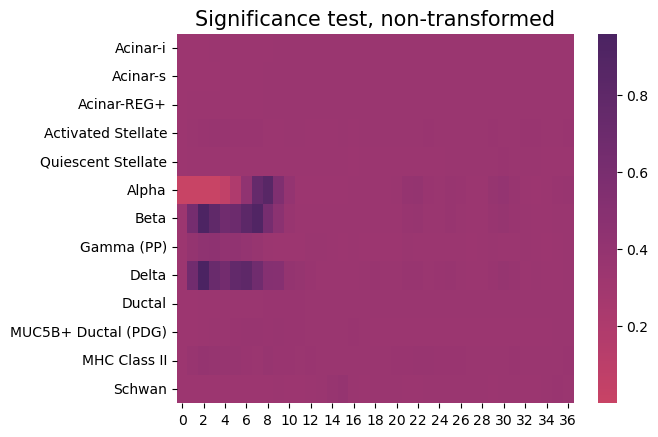

In [143]:
sns.heatmap(p_values_for_significance_test, cmap="flare", center = 0.05, yticklabels = relevant_cluster_labels)
plt.title("Significance test, non-transformed")

Text(0.5, 1.0, 'Significance test, negative log-transformed')

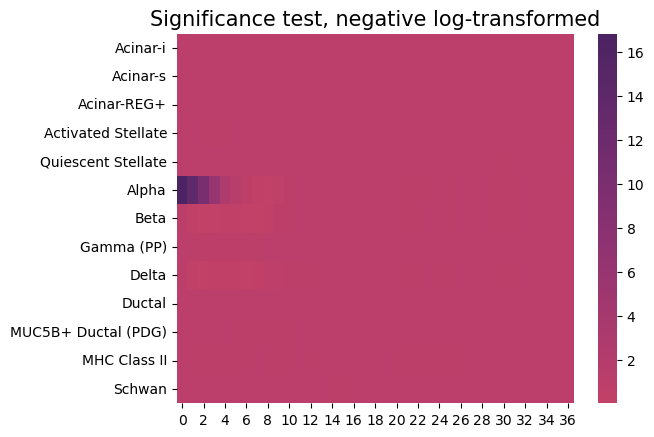

In [144]:
sns.heatmap(-np.log(p_values_for_significance_test), cmap="flare", center = 0.05, yticklabels = relevant_cluster_labels)
plt.title("Significance test, negative log-transformed")

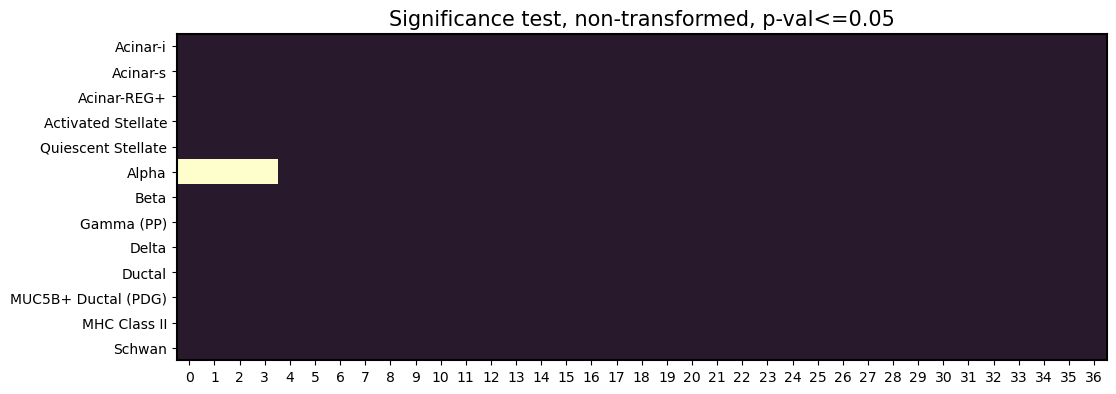

In [145]:
plt.figure(figsize=(12,5))
plt.imshow(p_values_for_significance_test < 0.05)
plt.xticks(np.arange(0,37))
plt.yticks(np.arange(0,13), relevant_cluster_labels)
plt.title("Significance test, non-transformed, p-val<=0.05")

plt.show()

In [136]:
# Log-transformmed

normalized_coocur_log = np.log(normalized_coocur)

p_values_for_significance_test = np.zeros((13,37))

for i in range(13):
    for j in range(37):
        value_to_test = normalized_coocur_log[5,i,j]
        t_statistic, p_value = stats.ttest_1samp(normalized_coocur_log[5,:,0], value_to_test)
        p_values_for_significance_test[i,j] = p_value

/tmp/ipykernel_976906/804334821.py:3: RuntimeWarning: invalid value encountered in log
  normalized_coocur_log = np.log(normalized_coocur)


In [137]:
def count_nan_values(array):
    nan_count = np.count_nonzero(np.isnan(array))
    return nan_count
count_nan_values(normalized_coocur_log)

94

/dh-projects/ag-ishaque/analysis/anastasiia/anaconda3/envs/sonar/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/dh-projects/ag-ishaque/analysis/anastasiia/anaconda3/envs/sonar/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

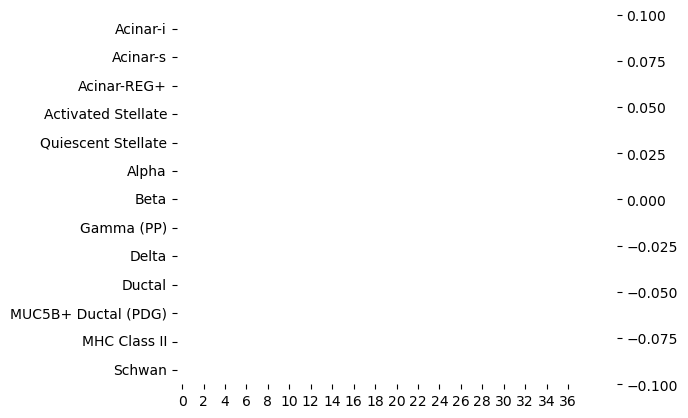

In [135]:
sns.heatmap(p_values_for_significance_test, cmap="flare", center = 0.05, yticklabels = relevant_cluster_labels, mask=np.isnan(p_values_for_significance_test))

In [223]:
relevant_cluster_labels

['Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan']

(-0.001, 0.01)

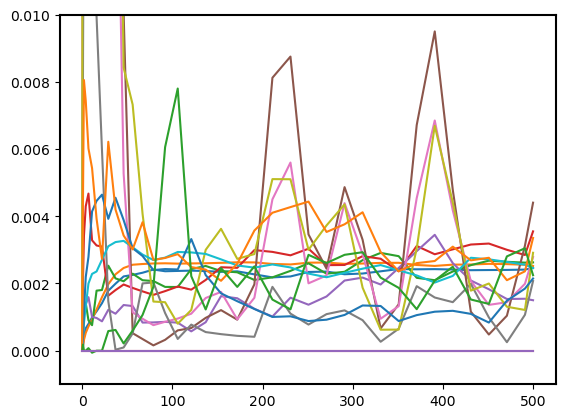

In [25]:
plt.plot(radii,normalized_coocur[5,].T)
plt.ylim(-0.001,0.01)

In [27]:
cooc_template_.shape

(15, 15, 37)

## Propper Showcase building

In [358]:
# Define the dimensions of the tissue tensor
n_celltypes = 1  # Replace with the desired number of cell types
desired_width = 10  # Replace with the desired width of the tissue
desired_height = 10  # Replace with the desired height of the tissue
cell_rad = 1
distance = 3

# Initialize the 'empty' tissue tensor filled with zeros

# tissue_tensor = np.zeros((n_celltypes, desired_width, desired_height))

tissue_tensor = np.zeros((desired_width, desired_height))
tissue_tensor

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [359]:
# Create the mesh grid as in the previous code
# phi = (np.sqrt(5) + 1) / 2
# fig_width = 10
N = desired_width * desired_height
ratio = np.sqrt(3) / 2
N_X = int(np.sqrt(N / ratio))
N_Y = N // N_X

xv, yv = np.meshgrid(np.arange(0, N_X, distance), np.arange(0, N_Y, distance), sparse=False, indexing='xy')
xv = xv * ratio
xv[::2, :] += (ratio/2) * distance

In [360]:
np.max([xv,yv])

9.093266739736606

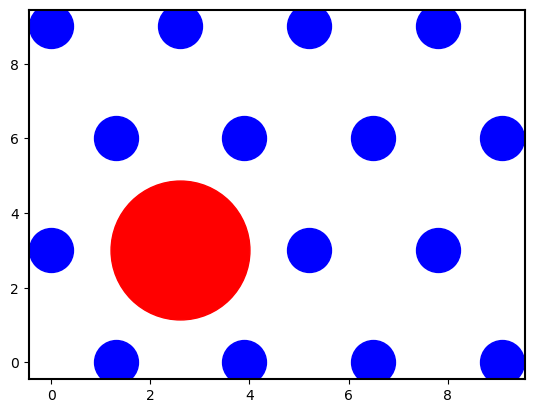

In [380]:
# fig, ax = plt.figure()
plt.scatter(xv, yv, s=1000, color = "blue")
plt.scatter(xv[1,1], yv[1,1], s=10000, color = "red")

In [381]:
xv.shape

(4, 4)

In [16]:
plt.figure(figsize=[5,5])

def create_mat(radius=20,size=400):
    span = np.linspace(-1,1,size)
    X,Y = np.meshgrid(span,span)
    
    cone = 1-(X**2+Y**2)**0.5
    
    return (cone>(1-(radius/size*2)))

<Figure size 500x500 with 0 Axes>

In [17]:
single_cell = create_mat(radius=cell_rad,size=cell_rad*2)

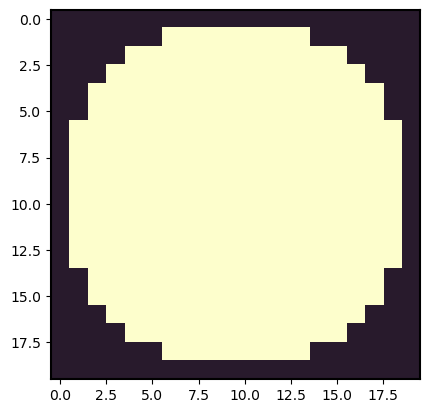

In [18]:
plt.imshow(single_cell)

In [19]:
XV = xv.astype(int)
YV = yv.astype(int)

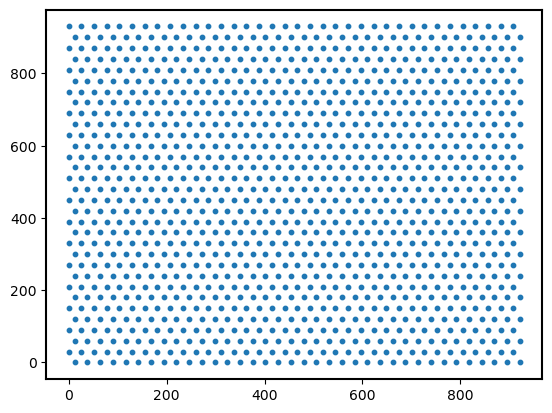

In [20]:
plt.scatter(XV, YV, s=10)

In [21]:
tissue_tensor.shape

(1000, 1000)

In [22]:
# Here we can select some cells and make them of a different cell type
# tissue_tensor[XV[:-2], YV[:-2]] = 1 # Due to N_X and N_Y swap in meshgrid creation

tissue_tensor[XV, YV] = 1

In [23]:
np.max(YV)

930

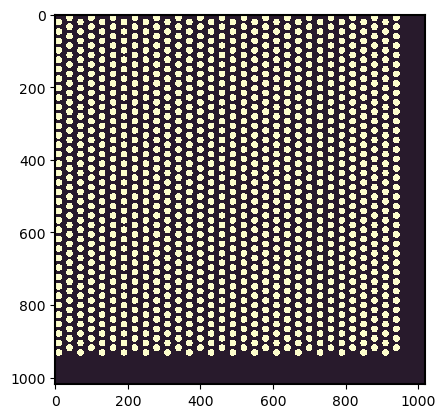

In [24]:
new_matrix = signal.convolve(tissue_tensor, single_cell)
plt.imshow(new_matrix)

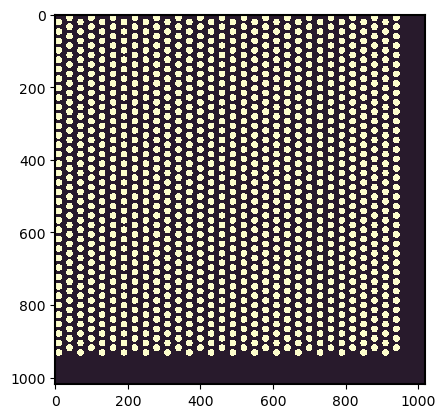

In [25]:
plt.imshow(new_matrix)

# Correct showcase

In [45]:
# Sebastian's help

import numpy as np
import matplotlib.pyplot as plt

def hexagonal_grid_coordinates(n, size):

    n = n/np.sqrt(3)

    # Compute x and y offsets for each hexagon
    x_offset = np.sqrt(3) * n
    y_offset = 1.5 * n

    # Determine the number of hexagons along the x and y axes based on the given size
    num_x_hexagons = int(np.ceil(size[0] / x_offset))
    num_y_hexagons = int(np.ceil(size[1] / y_offset))

    # Initialize arrays to store x and y coordinates
    x_coords = np.zeros((num_y_hexagons, num_x_hexagons))
    y_coords = np.zeros((num_y_hexagons, num_x_hexagons))

    for i in range(num_y_hexagons):
        for j in range(num_x_hexagons):
            # Compute the x, y coordinates for each hexagon's center
            x_coords[i, j] = j * x_offset
            y_coords[i, j] = i * y_offset

            # For odd-numbered rows, shift the x-coordinate by half the x offset
            if i % 2 != 0:
                x_coords[i, j] += 0.5 * x_offset

    return x_coords, y_coords

# # Example usage:
# n_pixel_units = 20 # distance between cells
# grid_size = (500, 500)
# x_coords, y_coords = hexagonal_grid_coordinates(n_pixel_units, grid_size)

# plt.scatter(x_coords, y_coords, s=10)

In [46]:
plt.figure(figsize=[5,5])

def create_mat(radius=20,size=400):
    span = np.linspace(-1,1,size)
    X,Y = np.meshgrid(span,span)
    
    cone = 1-(X**2+Y**2)**0.5
    
    return (cone>(1-(radius/size*2)))

<Figure size 500x500 with 0 Axes>

In [125]:
x_coords.shape

(39, 34)

IndexError: index 36 is out of bounds for axis 1 with size 34

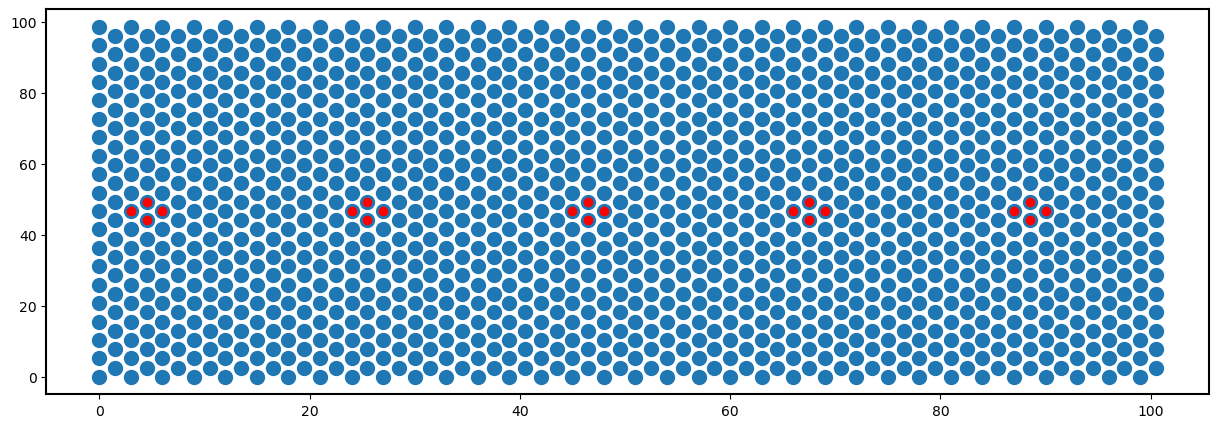

In [139]:
# A training set for the islet location determination
n_celltypes = 1  # Replace with the desired number of cell types
cell_rad = 1
n_pixel_units = 3 # distance between cells
grid_size = (100, 100)

x_coords, y_coords = hexagonal_grid_coordinates(n_pixel_units, grid_size)
# int_x_coords, int_y_coords = x_coords.astype(int), y_coords.astype(int)

hight = x_coords.shape[1]
width = x_coords.shape[0]

coords_list = []

fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(x_coords, y_coords, s=100)

for i in range(1,width, width//5):
    # ax.scatter(x_coords[hight//hight,width//width-1+i], y_coords[hight//hight,width//width-1+i], color = 'red')
    # ax.scatter(x_coords[hight//hight+1,width//width-1+i], y_coords[hight//hight+1,width//width-1+i], color = 'red')
    # ax.scatter(x_coords[hight//hight+1,width//width+i], y_coords[hight//hight+1,width//width+i], color = 'red')
    # ax.scatter(x_coords[hight//hight+2,width//width-1+i], y_coords[hight//hight+2,width//width-1+i], color = 'red')

  
    # ax.scatter(x_coords[1,1-1+i], y_coords[1,1-1+i], color = 'red')
    # ax.scatter(x_coords[1+1,1-1+i], y_coords[1+1,1-1+i], color = 'red')
    # ax.scatter(x_coords[1+1,1+i], y_coords[1+1,1+i], color = 'red')
    # ax.scatter(x_coords[1+2,1-1+i], y_coords[1+2,1-1+i], color = 'red')

    ax.scatter(x_coords[hight//2,i], y_coords[hight//2,i], color = 'red')
    ax.scatter(x_coords[hight//2+1,i], y_coords[hight//2+1,i], color = 'red')
    ax.scatter(x_coords[hight//2+1,1+i], y_coords[hight//2+1,1+i], color = 'red')
    ax.scatter(x_coords[hight//2+2,i], y_coords[hight//2+2,i], color = 'red')

    c1 = hight//2,i
    c2 = hight//2+1,i
    c3 = hight//2+1,1+i
    c4 = hight//2+2,i

    coords_list.append([c1, c2, c3, c4])

print(coords_list)

#     coords_list.append([hight//hight,width//width-1+i,
#                         hight//hight+1,width//width-1+i,
#                         hight//hight+1,width//width+i,
#                         hight//hight+2,width//width-1+i]
#                         )
    
# ax.scatter(x_coords[coords_list[0][0]], y_coords[coords_list[0][1]], color = 'red')
# ax.scatter(x_coords[coords_list[0][2]], y_coords[coords_list[0][3]], color = 'red')
# ax.scatter(x_coords[coords_list[0][4]], y_coords[coords_list[0][5]], color = 'red')
# ax.scatter(x_coords[coords_list[0][6]], y_coords[coords_list[0][7]], color = 'red')


    # ax.scatter(x_coords[(hight//hight)+8,int((width//width-1+i)*1.5)], y_coords[(hight//hight)+8,int((width//width-1+i)*1.5)], color = 'red')

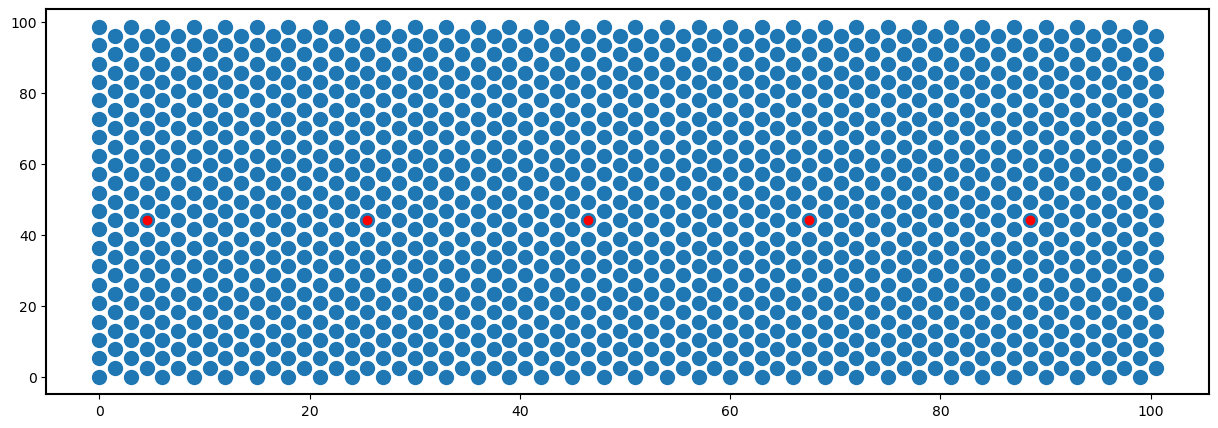

In [143]:
fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(x_coords, y_coords, s=100)

for i in range(5):
    ax.scatter(x_coords[coords_list[i][0]], y_coords[coords_list[i][0]], color = 'red')

In [172]:
coords_list

[[(17, 1), (18, 1), (18, 2), (19, 1)],
 [(17, 8), (18, 8), (18, 9), (19, 8)],
 [(17, 15), (18, 15), (18, 16), (19, 15)],
 [(17, 22), (18, 22), (18, 23), (19, 22)],
 [(17, 29), (18, 29), (18, 30), (19, 29)]]

In [166]:
cell_rad = 3
n_pixel_units = 8 # distance between cells
grid_size = (100, 100)
x_coords, y_coords = hexagonal_grid_coordinates(n_pixel_units, grid_size)

tissue_tensor = np.zeros((grid_size[0], grid_size[1]))
single_cell = create_mat(radius=cell_rad,size=cell_rad*2)

int_x_coords, int_y_coords = x_coords.astype(int), y_coords.astype(int)

tissue_tensor[int_x_coords[:,:-1], int_y_coords[:,:-1]] = 1

In [176]:
for i in range(5):
    for j in coords_list[i]:
        tissue_tensor[int_x_coords[j], int_y_coords[j]] = 2

IndexError: index 17 is out of bounds for axis 0 with size 15

In [177]:
circle_grid = signal.convolve(tissue_tensor, single_cell).round()

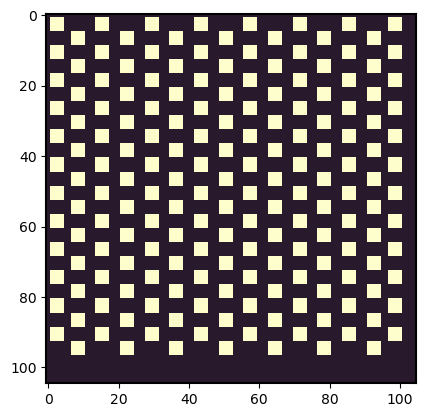

In [178]:
plt.imshow(circle_grid)

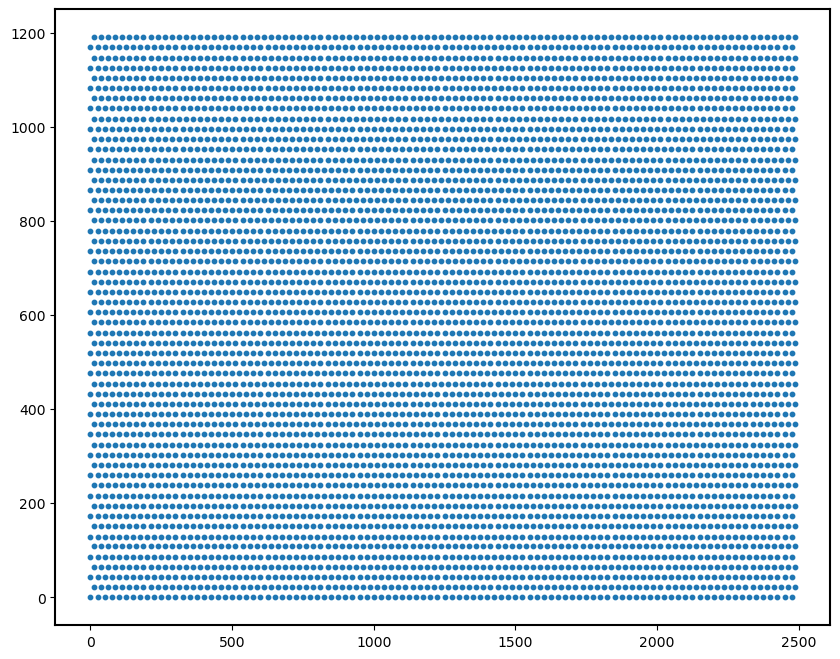

In [49]:
# Define the parameters for the future tissue tensor
n_celltypes = 1  # Replace with the desired number of cell types
cell_rad = 10
n_pixel_units = 25 # distance between cells
grid_size = (2500, 1200)

x_coords, y_coords = hexagonal_grid_coordinates(n_pixel_units, grid_size)
int_x_coords, int_y_coords = x_coords.astype(int), y_coords.astype(int)

fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(int_x_coords, int_y_coords, s=cell_rad)

## larger circles which are supposed to be islets
# for h in range(3,12,8):
#     for i in range(1,len(int_x_coords[1]), int_x_coords.shape[0]//3):
#         ax.scatter(int_x_coords[h,i], int_y_coords[h,h], s=cell_rad*25)


In [418]:
for i in range(1,len(int_x_coords[1]), int_x_coords.shape[0]//4):
    print(i)

1
15
29
43
57
71
85
99


In [343]:
# plt.scatter(x_coords, y_coords, s=cell_rad, color = 'blue')

# plt.scatter(x_coords[1,1], y_coords[5,5], s=cell_rad, color = 'red')
# plt.scatter(x_coords[2,2], y_coords[6,6], s=cell_rad, color = 'red')
# plt.scatter(x_coords[2,1], y_coords[6,5], s=cell_rad, color = 'red')

In [351]:
x_coords.shape

(56, 100)

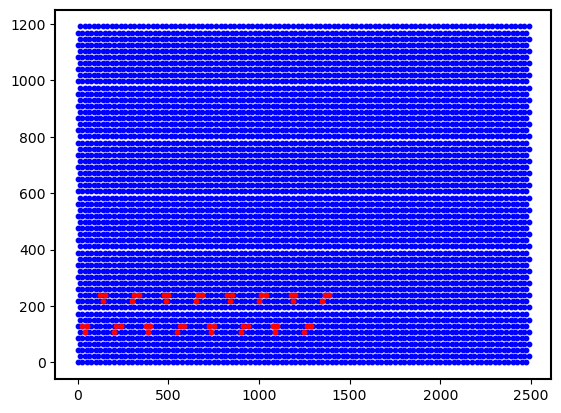

In [350]:
plt.scatter(x_coords, y_coords, s=cell_rad, color = 'blue')

islet_interval = x_coords.shape[0]
islet_hight = y_coords.shape[1]//20

def draw_islets(num_of_islets=8, h=1):
    """Automatic drawing of islets
    num_of_islets, int: num of islets per line.
    h, int: the hight of islets in a sample.
    """
    for i in range(1,islet_interval,(islet_interval//num_of_islets)):
        
        plt.scatter(x_coords[i,i], y_coords[islet_hight*h,islet_hight*h], s=cell_rad, color = 'red')
        plt.scatter(x_coords[i+1,i+1], y_coords[islet_hight*h+1,islet_hight*h+1], s=cell_rad, color = 'red')
        plt.scatter(x_coords[i+1,i], y_coords[islet_hight*h+1,islet_hight*h], s=cell_rad, color = 'red')

        plt.scatter(x_coords[i+4,i+4], y_coords[islet_hight*2*h,islet_hight*2*h], s=cell_rad, color = 'red')
        plt.scatter(x_coords[i+5,i+5], y_coords[islet_hight*2*h+1,islet_hight*2*h+1], s=cell_rad, color = 'red')
        plt.scatter(x_coords[i+5,i+4], y_coords[islet_hight*2*h+1,islet_hight*2*h+1], s=cell_rad, color = 'red')
        
        
draw_islets()


In [306]:
print(x_coords.shape)
print(y_coords.shape)

(24, 20)
(24, 20)


In [313]:
x_coords[1]

array([ 12.5,  37.5,  62.5,  87.5, 112.5, 137.5, 162.5, 187.5, 212.5,
       237.5, 262.5, 287.5, 312.5, 337.5, 362.5, 387.5, 412.5, 437.5,
       462.5, 487.5])

In [ ]:
# x_coords = np.delete(x_coords, 21, axis=0)

In [464]:
# Initialize the 'empty' tissue tensor filled with zeros

# tissue_tensor = np.zeros((n_celltypes, desired_width, desired_height))
tissue_tensor = np.zeros((grid_size[0], grid_size[1]))

In [465]:
single_cell = create_mat(radius=cell_rad,size=cell_rad*2)

In [144]:
int_x_coords, int_y_coords = x_coords.astype(int), y_coords.astype(int)

In [467]:
# int_x_coords[int_x_coords > (grid_size[0]-1)] = (grid_size[0]-1)
# int_x_coords[int_x_coords > (grid_size[1]-1)] = (grid_size[1]-1)

In [468]:
tissue_tensor[int_x_coords, int_y_coords] = 1

In [469]:
# tissue_tensor[int_x_coords[1,1], int_y_coords[1,1]] = 2

islet_interval = x_coords.shape[0]
islet_hight = y_coords.shape[1]//4

num_of_islets = 3
h = 1

for i in range(1,islet_interval,(islet_interval//num_of_islets)):
        
    tissue_tensor[int_x_coords[i,i], int_y_coords[islet_hight*h,islet_hight*h]] = 2
    tissue_tensor[int_x_coords[i+1,i+1], int_y_coords[islet_hight*h+1,islet_hight*h+1]] = 2
    tissue_tensor[int_x_coords[i+1,i], int_y_coords[islet_hight*h+1,islet_hight*h]] = 2

    tissue_tensor[int_x_coords[i+4,i+4], int_y_coords[islet_hight*3*h,islet_hight*3*h]] = 2
    tissue_tensor[int_x_coords[i+5,i+5], int_y_coords[islet_hight*3*h+1,islet_hight*3*h+1]] = 2
    tissue_tensor[int_x_coords[i+5,i+4], int_y_coords[islet_hight*3*h+1,islet_hight*3*h+1]] = 2

IndexError: index 75 is out of bounds for axis 0 with size 56

In [470]:
circle_grid = signal.convolve(tissue_tensor, single_cell).round()

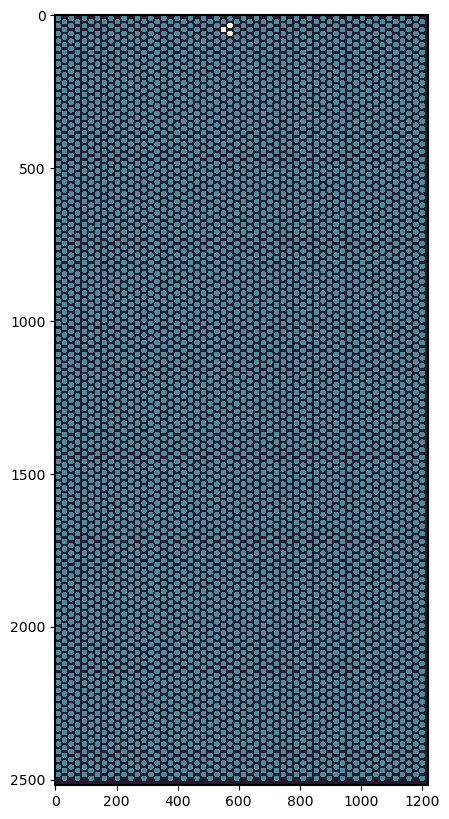

In [471]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.clear()
ax.imshow(circle_grid)

## Stats

In [35]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor((xv, yv),interpolate=True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650977166858/work/torch/csrc/utils/tensor_new.cpp:207.)
  hists = t.tensor(hists,dtype=torch.float32,device=self.device)


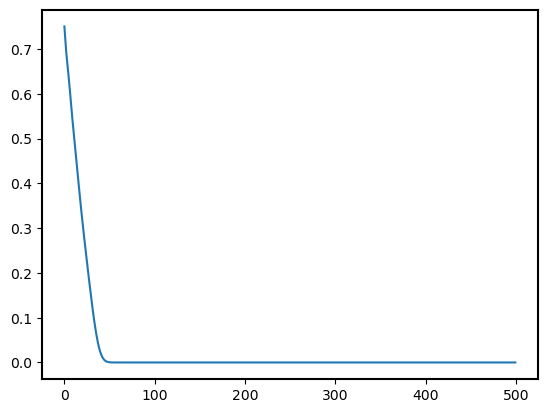

In [36]:
plt.plot(cooc_template_[0,1])

# Tissues, sonar

In [37]:
n_sample = 1

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

In [38]:
# Islet stack
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
# rescaled_splitted = np.split(rescaled, 16)
# islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor(rescaled,interpolate=True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:204: RuntimeWarning: invalid value encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])


In [39]:
# plt.figure(figsize=[15,5])
# plt.plot(cooc_template_[6,7])
# plt.ylim(-0.001,0.01)

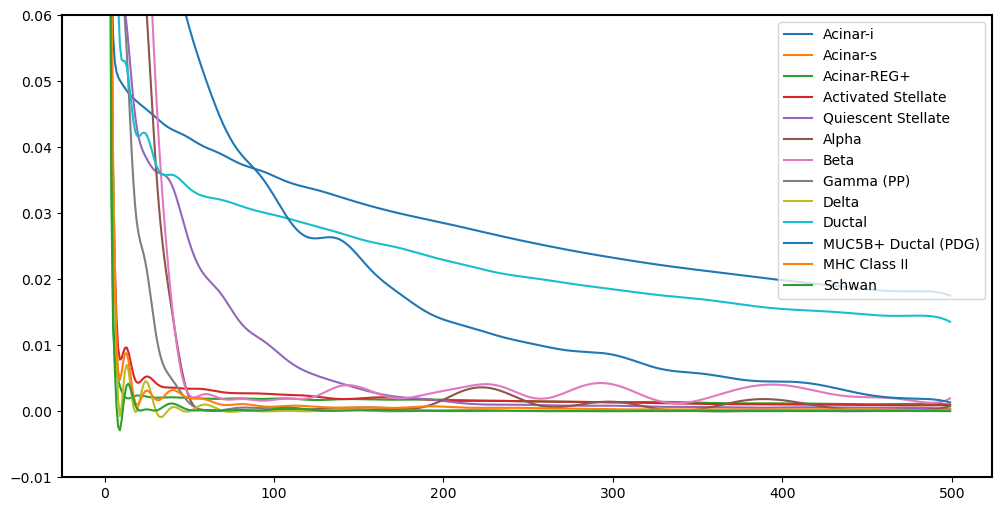

In [40]:
plt.figure(figsize=[12,6])

for i in range(1,14):
    # plt.plot(cooc_template_[6,7])
    plt.plot(cooc_template_[i,i])

# plt.plot(cooc_template_islet[0,0])
plt.ylim(-0.01,0.06)
plt.legend(cluster_labels[1:14], loc="upper right")

76427.0
696597.0
4112.0
3774.0
4405.0
2195.0
7873.0
547.0
249.0
56161.0
8143.0
1017.0
222.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Acinar-i'),
  Text(1, 0, 'Acinar-s'),
  Text(2, 0, 'Acinar-REG+'),
  Text(3, 0, 'Activated Stellate'),
  Text(4, 0, 'Quiescent Stellate'),
  Text(5, 0, 'Alpha'),
  Text(6, 0, 'Beta'),
  Text(7, 0, 'Gamma (PP)'),
  Text(8, 0, 'Delta'),
  Text(9, 0, 'Ductal'),
  Text(10, 0, 'MUC5B+ Ductal (PDG)'),
  Text(11, 0, 'MHC Class II'),
  Text(12, 0, 'Schwan')])

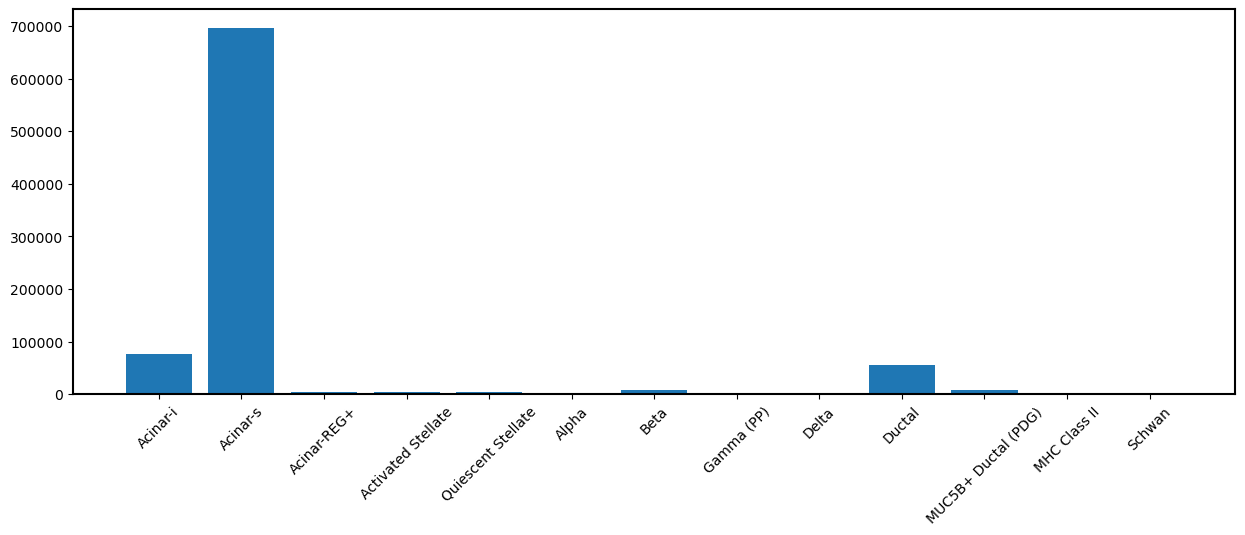

In [41]:
plt.figure(figsize=[15,5])
tissue_pixels = []
for i in range(1,14):
    pix_agreg = np.sum(rescaled[i])
    tissue_pixels.append(pix_agreg)
    print(pix_agreg)

plt.bar(cluster_labels[1:14],tissue_pixels)
plt.xticks(rotation=45)

Probability distribution

In [42]:
probab_distr = []
for cell_type in tissue_pixels:
    p_cell_type = cell_type/sum(tissue_pixels)
    probab_distr.append(p_cell_type)
print(probab_distr)

[0.08869101636026468, 0.8083778759275033, 0.0047718405703927715, 0.0043796027024957, 0.005111857420374552, 0.0025472252072013942, 0.009136357201046276, 0.0006347754844369762, 0.0002889562991312744, 0.06517299082534739, 0.00944968330853802, 0.0011801950048855663, 0.00025762368838210003]


In [43]:
for rad in range(500):
    cooc_template_changed[:,:,rad] = cooc_template_[:,:,rad]*2*math.pi*rad

for i in range(1,14):
    # plt.plot(cooc_template_[6,7])
    plt.plot(cooc_template_changed[i,i])

NameError: name 'cooc_template_changed' is not defined

In [ ]:
# test with 3 uniformly distributed values

co_occurrence_test

In [ ]:
scipy.stats.binomtest(int(cooc_template_changed[6,6][200]), int(200*2*math.pi), p=probab_distr[6])

BinomTestResult(k=2, n=1256, alternative='two-sided', statistic=0.0015923566878980893, pvalue=0.0015561304470760793)